# Evaluate the generated data against the real data
### We will use the following metrics:
- 1. Phase-averaged $R^2$
- 2. Cross-correlation
- 3. FFT comparison
- 4. Dynamic Time Warping (DTW)


### Import libraries

In [25]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Load the data

In [27]:
gen_data = jnp.load("outputs/gen_human_data.npy")
real_data = jnp.load("outputs/real_human_data.npy")

print("The generated data has shape: ", gen_data.shape)
print("The real data has shape: ", real_data.shape)


The generated data has shape:  (12, 2000, 12)
The real data has shape:  (12, 28560, 12)


### Define helper functions

In [28]:
# Helper functions
@jit
def normalize_signal(signal):
    """Normalize a single signal"""
    mean = jnp.mean(signal)
    std = jnp.std(signal)
    return (signal - mean) / std

# Vectorized version for multiple signals
vnormalize = vmap(normalize_signal, in_axes=0, out_axes=0)

@jit
def euclidean_distance(x, y):
    """Compute euclidean distance between two points"""
    return jnp.sqrt(jnp.sum((x - y) ** 2))

@jit
def cross_correlation(signal1, signal2):
    """Compute normalized cross-correlation for single pair of signals"""
    # Normalize signals
    s1_norm = normalize_signal(signal1)
    s2_norm = normalize_signal(signal2)
    
    # Calculate cross-correlation
    xcorr = jnp.correlate(s1_norm, s2_norm, mode='full')
    
    # Return maximum correlation coefficient
    return jnp.max(jnp.abs(xcorr)) / signal1.shape[0]

# Vectorized version for multiple signal pairs
vcross_correlation = vmap(cross_correlation, in_axes=(0, 0), out_axes=0)

@jit
def fft_comparison(signal1, signal2):
    """Compare frequency components of two signals"""
    # Compute FFTs
    fft1 = jnp.fft.fft(signal1)
    fft2 = jnp.fft.fft(signal2)
    
    # Compare magnitude spectra
    mag1 = jnp.abs(fft1)
    mag2 = jnp.abs(fft2)
    
    # Normalize
    mag1_norm = mag1 / jnp.max(mag1)
    mag2_norm = mag2 / jnp.max(mag2)
    
    return jnp.mean(jnp.abs(mag1_norm - mag2_norm))

# Vectorized version for multiple signal pairs
vfft_comparison = vmap(fft_comparison, in_axes=(0, 0), out_axes=0)

@jit
def simplified_dtw(signal1, signal2, window_size=10):
    """
    Simplified DTW implementation that's JAX-friendly
    Uses a constrained window for better performance
    """
    n, m = signal1.shape[0], signal2.shape[0]
    
    # Initialize cost matrix
    cost_matrix = jnp.full((n + 1, m + 1), jnp.inf)
    cost_matrix = cost_matrix.at[0, 0].set(0)
    
    def scan_fn(prev_row, curr_idx):
        curr_row = jnp.full(m + 1, jnp.inf)
        curr_row = curr_row.at[0].set(jnp.inf)
        
        i = curr_idx + 1
        
        def update_cell(j):
            cost = euclidean_distance(signal1[i-1], signal2[j-1])
            new_cost = cost + jnp.min(jnp.array([
                prev_row[j],
                prev_row[j-1],
                curr_row[j-1]
            ]))
            
            return jax.lax.cond(
                jnp.abs(i - j) <= window_size,
                lambda _: new_cost,
                lambda _: jnp.inf,
                operand=None
            )
        
        j_indices = jnp.arange(1, m + 1)
        costs = vmap(update_cell)(j_indices)
        curr_row = curr_row.at[1:].set(costs)
        
        return curr_row, curr_row
    
    # Scan over all rows
    final_row, _ = jax.lax.scan(
        scan_fn,
        cost_matrix[0],
        jnp.arange(n)
    )
    
    # Return just the final DTW distance
    return final_row[-1]

# Vectorized version for multiple signal pairs
vsimplified_dtw = vmap(simplified_dtw, in_axes=(0, 0), out_axes=0)

@jit
def comprehensive_comparison(signal1, signal2):
    """Compute all metrics for a single pair of signals"""
    return {
        'dtw': simplified_dtw(signal1, signal2),
        'xcorr': cross_correlation(signal1, signal2),
        'fft': fft_comparison(signal1, signal2)
    }

# Example usage with batched data
def batch_compare_signals(signals1, signals2):
    """
    Compare multiple pairs of signals at once
    
    Args:
        signals1: Array of shape (batch_size, signal_length)
        signals2: Array of shape (batch_size, signal_length)
    """
    return {
        'dtw': vsimplified_dtw(signals1, signals2),
        'xcorr': vcross_correlation(signals1, signals2),
        'fft': vfft_comparison(signals1, signals2)
    }

### Calculate evaluation metrics

In [45]:
batch_signals1 = jnp.copy(data[:, :new_ts.shape[0], :])  # shape: (batch_size, signal_length)
batch_signals2 = jnp.copy(out[:, :, :])  # shape: (batch_size, signal_length)


batch_results = jax.vmap(lambda x, y: batch_compare_signals(x, y), in_axes=(2, 2))(batch_signals1, batch_signals2)
print(batch_results.keys())

dict_keys(['dtw', 'fft', 'xcorr'])


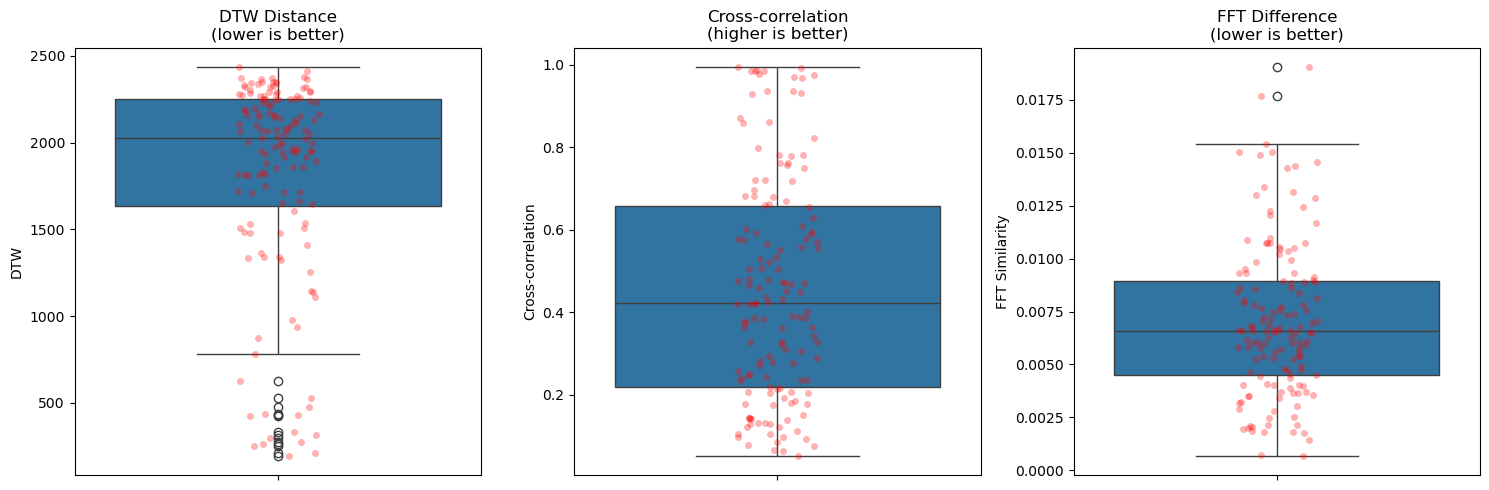


Summary Statistics:
               DTW  Cross-correlation  FFT Similarity       Trial
count   144.000000         144.000000      144.000000  144.000000
mean   1812.756033           0.453599        0.007052   71.500000
std     593.936558           0.270173        0.003633   41.713307
min     195.565346           0.052173        0.000686    0.000000
25%    1636.351900           0.217700        0.004482   35.750000
50%    2024.347015           0.421582        0.006574   71.500000
75%    2249.067877           0.656644        0.008942  107.250000
max    2434.238093           0.993630        0.019050  143.000000


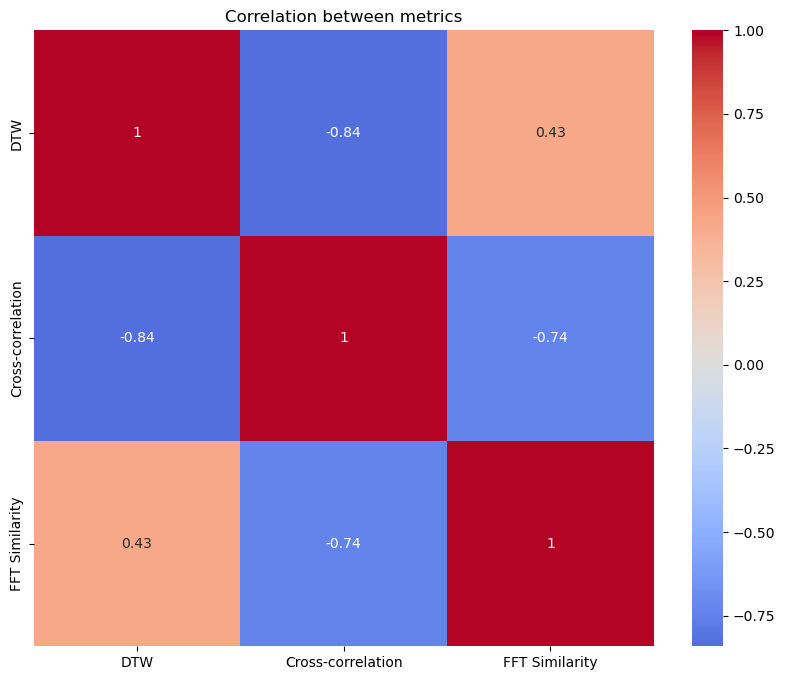

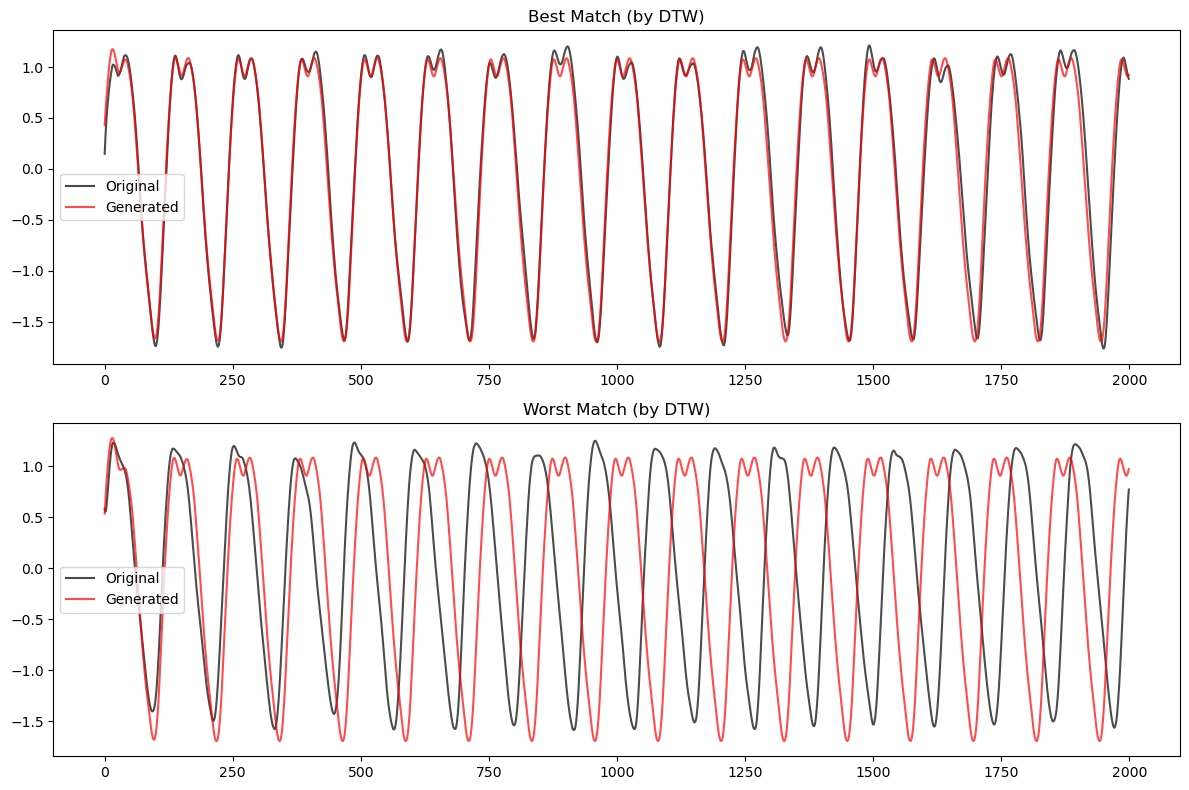

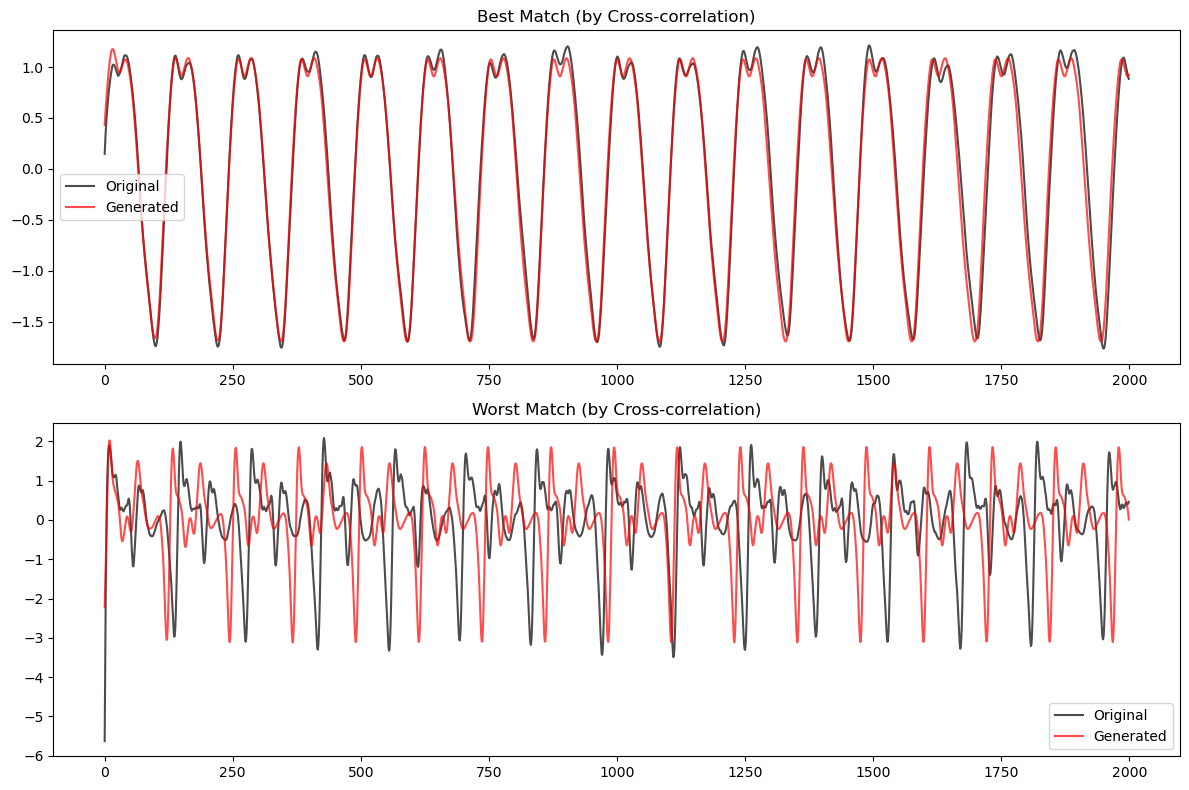

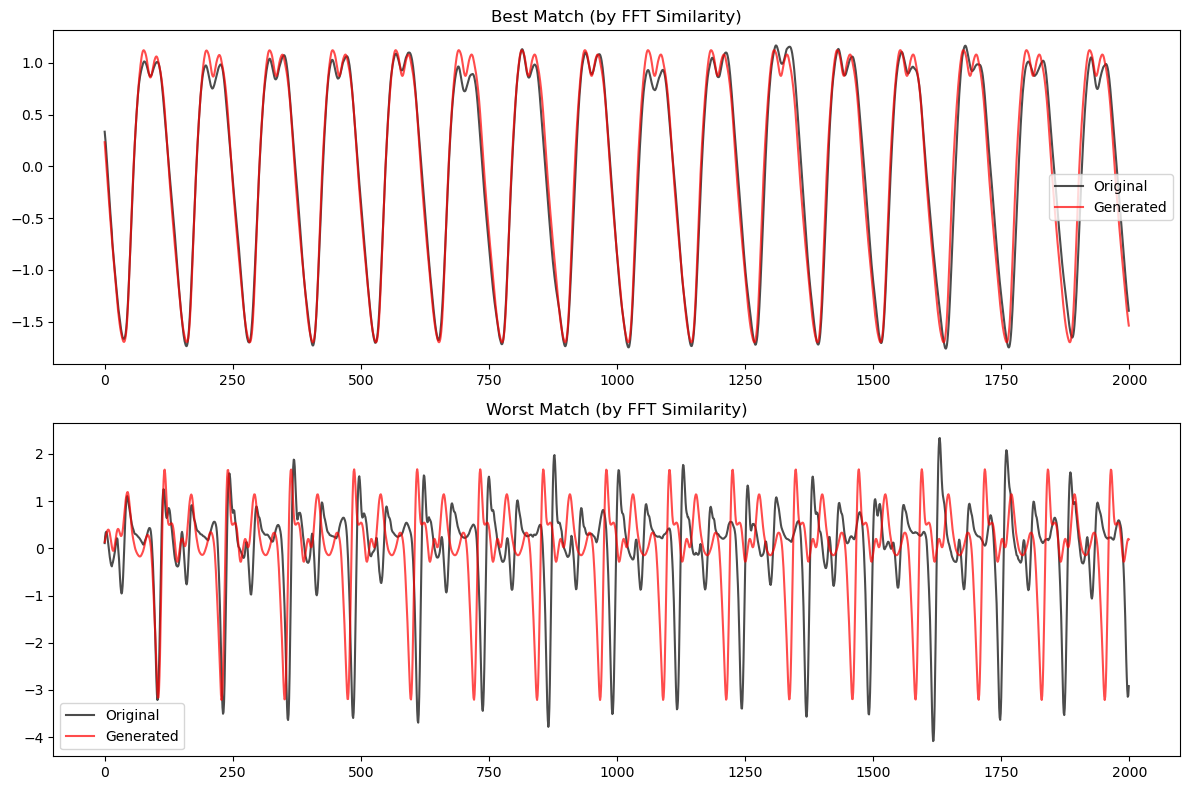

In [61]:

# Convert batch results to a DataFrame for easier plotting
def plot_comparison_results(batch_results, figsize=(15, 5)):
    # Create DataFrame
    results_df = pd.DataFrame({
        'DTW': batch_results['dtw'].flatten(),
        'Cross-correlation': batch_results['xcorr'].flatten(),
        'FFT Similarity': batch_results['fft'].flatten(),
        'Trial': range(len(batch_results['dtw'].flatten()))
    })
    
    # Create subplot for each metric
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # DTW plot (lower is better)
    sns.boxplot(y='DTW', data=results_df, ax=axes[0])
    sns.stripplot(y='DTW', data=results_df, color='red', alpha=0.3, ax=axes[0])
    axes[0].set_title('DTW Distance\n(lower is better)')
    
    # Cross-correlation plot (higher is better)
    sns.boxplot(y='Cross-correlation', data=results_df, ax=axes[1])
    sns.stripplot(y='Cross-correlation', data=results_df, color='red', alpha=0.3, ax=axes[1])
    axes[1].set_title('Cross-correlation\n(higher is better)')
    
    # FFT Similarity plot (lower is better)
    sns.boxplot(y='FFT Similarity', data=results_df, ax=axes[2])
    sns.stripplot(y='FFT Similarity', data=results_df, color='red', alpha=0.3, ax=axes[2])
    axes[2].set_title('FFT Difference\n(lower is better)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(results_df.describe())
    
    return results_df

# Plot the results
results_df = plot_comparison_results(batch_results)

# Optional: Plot correlation between metrics
plt.figure(figsize=(10, 8))
sns.heatmap(results_df[['DTW', 'Cross-correlation', 'FFT Similarity']].corr(), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between metrics')
plt.show()

# Optional: Plot worst and best matches
def plot_extreme_cases(batch_signals1, batch_signals2, results_df, metric='DTW'):
    best_idx = results_df[metric].argmin() if metric in ['DTW', 'FFT Similarity'] else results_df[metric].argmax()
    worst_idx = results_df[metric].argmax() if metric in ['DTW', 'FFT Similarity'] else results_df[metric].argmin()
    
    best_idx = jnp.unravel_index(best_idx, (batch_signals1.shape[0], batch_signals1.shape[2]))
    worst_idx = jnp.unravel_index(worst_idx, (batch_signals1.shape[0], batch_signals1.shape[2]))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Best match
    ax1.plot(batch_signals1[best_idx[0], :, best_idx[1]], label='Original', alpha=0.7, c="black")
    ax1.plot(batch_signals2[best_idx[0], :, best_idx[1]], label='Generated', alpha=0.7, c="red")
    ax1.set_title(f'Best Match (by {metric})')
    ax1.legend()
    
    # Worst match
    ax2.plot(batch_signals1[worst_idx[0], :, worst_idx[1]], label='Original', alpha=0.7, c="black")
    ax2.plot(batch_signals2[worst_idx[0], :, worst_idx[1]], label='Generated', alpha=0.7, c="red")
    ax2.set_title(f'Worst Match (by {metric})')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot extreme cases for each metric
for metric in ['DTW', 'Cross-correlation', 'FFT Similarity']:
    plot_extreme_cases(batch_signals1, batch_signals2, results_df, metric)